# Hi :)

----

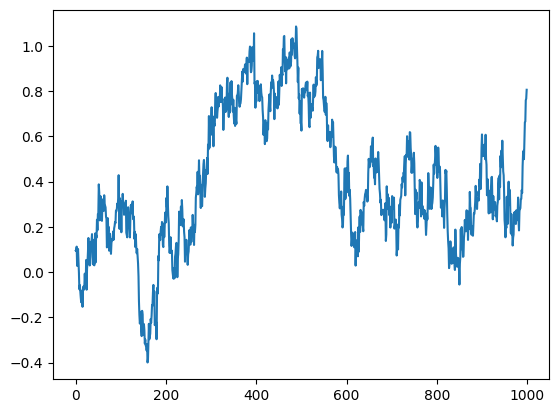

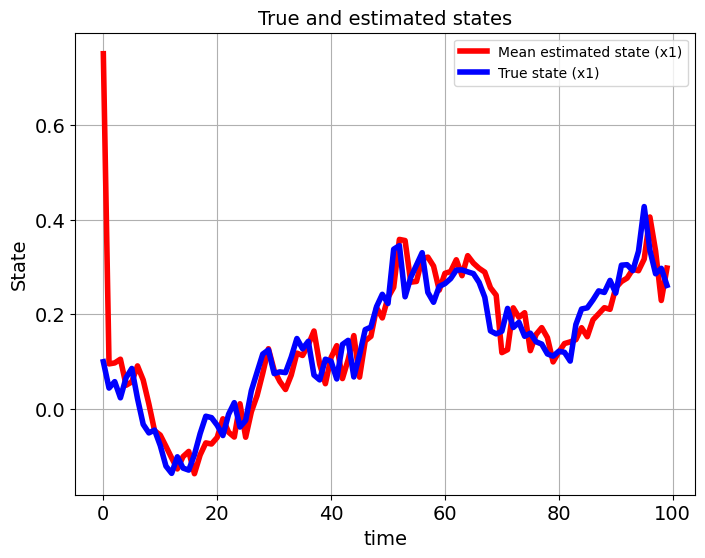

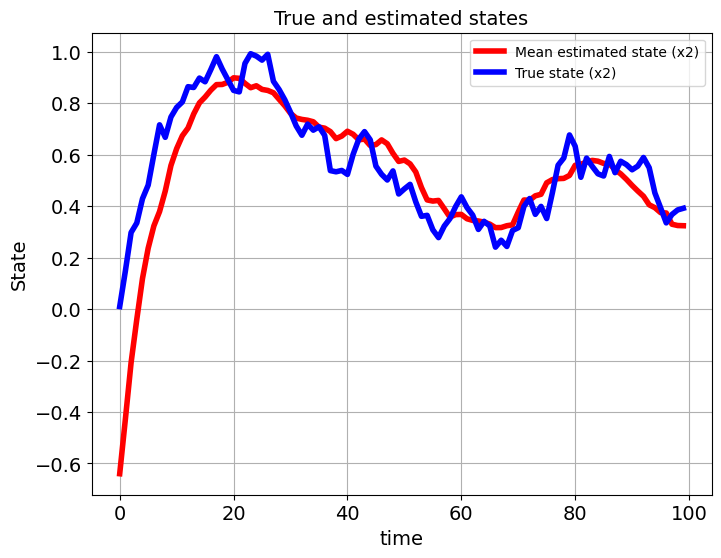

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def systematicResampling(weightArray):
    # total number of samples
    N= len(weightArray)
    #cummulative sum of weights
    cValues= []
    cValues.append(weightArray[0])

    for i in range(N - 1):
        cValues.append(cValues[i] + weightArray[i + 1])

    # starting random points
    startingPoint= np.random.uniform(low= 0, high= 1 / N)

    # this list stores indices of resampled states
    resampleIndex= []
    for i in range(N):
        currentPoint= startingPoint + 1 / N * i
        s= 0
        while (currentPoint > cValues[s]):
            s += 1

        resampleIndex.append(s)

    return resampleIndex

# define the statistics of the process disturbance
meanProcess= np.array([0, 0])
covarianceProcess= np.array([[0.002, 0], [0, 0.002]])

# define the statistics of the measurement noise
meanNoise= np.array([0])
covarianceNoise= np.array([[0.001]])

# create distributions of the process disturbance and measurement noise
processDistribution= multivariate_normal(mean= meanProcess, cov= covarianceProcess)
noiseDistribution= multivariate_normal(mean= meanNoise, cov= covarianceNoise)

# construct a state space model
# mass-spring damper system

# first construct a continuous-time system
m= 5
ks= 200
kd= 30

Ac= np.array([[0, 1], [-(ks / m), -(kd - m)]])
Cc= np.array([[1, 0]])
Bc= np.array([[0], [1 / m]])

# discretize the system
# discretization constant
h= 0.01

A= np.linalg.inv(np.eye(2) - h * Ac)
B= h * np.matmul(A, Bc)
C= Cc

# simulate the dynamics to get the state-space trajectory
simTime= 1000

# select the initial state for simulating the state trajectory and output
x0= np.array([[0.1], [0.01]])

stateDim, tmp11= x0.shape

# control input
controlInput= 100 * np.ones((1, simTime))

# this array is used to store the state trajectory
stateTrajectory= np.zeros(shape= (stateDim, simTime + 1))

# this array is used to store the output trajectory
output= np.zeros(shape= (1, simTime))

# set the initial state
stateTrajectory[:, [0]]= x0

# simulate the state-space model
for i in range(simTime):
    stateTrajectory[:, [i + 1]]= np.matmul(A, stateTrajectory[:, [i]]) + np.matmul(B, controlInput[:, [i]]) + processDistribution.rvs(size= 1).reshape(stateDim, 1)
    output[:, [i]]= np.matmul(C, stateTrajectory[:, [i]]) + noiseDistribution.rvs(size= 1).reshape(1, 1)

# here you can plot the output trajectory, just for verification
plt.plot(output[0])
plt.show()

# implementation of particle filter
# create an initial set of particles

#initial guess of the state
x0Guess= x0 + np.array([[0.7], [-0.6]])
pointsX, pointsY= np.mgrid[x0Guess[0, 0] - 0.8 : x0Guess[0, 0] + 0.8 : 0.1, x0Guess[1, 0] - 0.5 : x0Guess[1, 0] + 0.5 : 0.1]
xVec= pointsX.reshape((-1, 1), order= "C")
yVec= pointsY.reshape((-1, 1), order= "C")

# initial set of states
# states at initial points are stored column-wise
states= np.hstack((xVec, yVec)).transpose()

dim1, numberParticle= states.shape

# initial set of weights
# uniform set of weights
weights= (1 / numberParticle) * np.ones((1, numberParticle))

#number of iteration of the particle filter
numberIteration= 1000

# this list used to store the states and track convergence
stateList= []
stateList.append(states)
# this list used to store the weights and track convergence
weightList= []
weightList.append(weights)

# this is the main iteration of the particle filter algorithm
# k= 1, 2, 3, ...
for i in range(numberIteration):
    # STEP 1:
    # here we sample states by using the state transition probability
    # we apply the same input to every particle
    controlInputBatch= controlInput[0, i] * np.ones((1, numberParticle))
    # these are the states sampled from the transition probability
    newStates= np.matmul(A, states) + np.matmul(B, controlInputBatch) + processDistribution.rvs(size= numberParticle).transpose()
    # create a vector for storing the weights

    # STEP 2:
    newWeights= np.zeros(shape= (1, numberParticle))
    # here we update the weights
    for j in range(numberParticle):
        # create a normal distribution on the basis of the current particle state
        meanDis= np.matmul(C, newStates[:, [j]])
        distribution0= multivariate_normal(mean= meanDis[0], cov= covarianceNoise)
        # update the weights
        newWeights[:, j]= distribution0.pdf(output[:, i]) * weights[:, [j]]

    # standardize the weights
    weightsStandardized= newWeights / newWeights.sum()

    # STEP 3:
    # calculate effective sample size - Neff
    tmpl= [val**2 for val in weightsStandardized]
    Neff= 1 / np.array(tmpl).sum()

    # resample if this condition is met
    if Neff < (numberParticle // 3):

        # first resampling approach - resampling according to the probabilities stored in the weights
        resampledStateIndex= np.random.choice(np.arange(numberParticle), numberParticle, p= weightsStandardized[0, :])

        # # second resampling approach - systematic resampling
        # resampledStateIndex= systematicResampling(weightsStandardized[0, :])
        
        newStates= newStates[:, resampledStateIndex]
        weightsStandardized= (1 / numberParticle) * np.ones((1, numberParticle))

    # for the next iteration
    states= newStates
    weights= weightsStandardized

    # save the state and weights
    stateList.append(states)
    weightList.append(weights)

# lets comute the ean state trajectory
meanStateSequence= np.zeros(shape= (stateDim, numberIteration))
for i in range(numberIteration):
    meanState= np.zeros(shape= (stateDim, 1))
    for j in range(numberParticle):
        meanState= meanState + weightList[i][:, j] * stateList[i][:, j].reshape(2, 1)

    meanStateSequence[:, [i]]= meanState

# comute the estimation error
# however, we need to do a statistical error analystic test
# we can't just compute the error norm
errorSequence= np.zeros(shape= (stateDim, numberIteration))
errorSequenceNorm= np.zeros(shape= (1, numberIteration))
for i in range(numberIteration):
    errorSequence[:, [i]]= meanStateSequence[:, [i]] - stateTrajectory[:, [i]]
    errorSequenceNorm[:, i]= np.linalg.norm(errorSequence[:, i], 2)

# plot the true and mean state trajectory
# state x1
plt.figure(figsize= (8, 6))
plt.plot(meanStateSequence[0, 0 : 100], color= 'red', linewidth= 4, label= 'Mean estimated state (x1)')
plt.plot(stateTrajectory[0, 0 : 100], color= 'blue', linewidth= 4, label= 'True state (x1)')
plt.title('True and estimated states', fontsize= 14)
plt.xlabel('time', fontsize= 14)
plt.ylabel('State', fontsize= 14)
plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
plt.grid(visible= True)
plt.legend(prop= {'size' : 10})
# plt.savefig('Pictures/stateX1.png', dpi= 484)
plt.show()

# plot the true and mean state trajectory
# state x2
plt.figure(figsize= (8, 6))
plt.plot(meanStateSequence[1, 0 : 100], color= 'red', linewidth= 4, label= 'Mean estimated state (x2)')
plt.plot(stateTrajectory[1, 0 : 100], color= 'blue', linewidth= 4, label= 'True state (x2)')
plt.title('True and estimated states', fontsize= 14)
plt.xlabel('time', fontsize= 14)
plt.ylabel('State', fontsize= 14)
plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
plt.grid(visible= True)
plt.legend(prop= {'size' : 10})
# plt.savefig('Pictures/stateX2.png', dpi= 484)
plt.show()

# # use this to generate a series of PG images for creating the animation
# for i in range(numberIteration):
#     print(i)
#     plt.figure(figsize= (8, 8))
#     plt.scatter(stateList[i][0, :], stateList[i][1, :], s= 5000 * weightList[i][0, :], label= 'Particles', c= weightList[i][0, :], cmap= 'virdis', alpha= 0.4)
#     plt.scatter(stateTrajectory[0, i], stateTrajectory[1, i], s= 300, c= 'r', marker= 'o', label= 'Exact State')
#     plt.xlim((-0.5, 1.5))
#     plt.ylim((-2, 2))
#     plt.xlabel('x1', fontsize= 14)
#     plt.ylabel('x2', fontsize= 14)
#     plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
#     plt.legend()
#     filename= 'Pictures/Scatter/particles' + str(i).zfill(4) + '.png'
#     time.sleep(0.1)
#     plt.savefig(filename, dpi= 484)
#     plt.show()